In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import GPy
import cvxpy

In [138]:
def gauss_gp(y, plot = False):
    """
    y: np n x 1 array of input data
    """   
    x = np.atleast_2d(np.linspace(0, y.shape[0] - 1, y.shape[0])).T
    
    # squared gaussian kernel
    kernel  = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

    # initialize gaussian process
    gp = GPy.models.GPRegression(x,y,kernel)
    
    # optimize gp
    gp.optimize()
  
    # point to predict at
    point = (x[-1] + 1).reshape(1, -1)
    
    # predict
    pred, sigma = gp.predict(point)
    
    return_frac = pred / y[-1] - 1
    
    # plotting
    if plot:
        plt.plot(list(y) + [pred])
    
    # return sharpe
    return return_frac[0,0], sigma

()


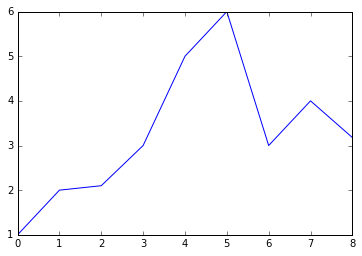

In [139]:
a = np.array([[1, 2, 2.1, 3, 5, 6,3 ,4]]).T
R, cov = gauss_gp(a, True)
print(R.shape)

In [140]:
def cov_return_sigma(X, sharpe_func):
    """
    X: n x k numpy array of stocks
    sharpe_func: function that takes an n x 1 array of input data and 
                 returns a tuple of return rate and std. deviation of 
                 that return rate
    """
    
    cov = np.cov(X)
    
    return_sigma = np.array([sharpe_func(X[i][:, np.newaxis]) for i in range(X.shape[0])])
    
    returns = return_sigma[:,0]
    sigma = return_sigma[:,1]
    
    return cov, returns, sigma
    

In [262]:
def read_stocks(dir_name):
    """
    dir_name: string directory name
    
    returns: stocks as rows all concatenated to min. length
    
    Assumes stocks are csv's
    """
    stock_files = glob.glob(dir_name + '/*.csv')
    
    labels = []
    
    X = []
    min_len = 100000
    
    for stock in stock_files:
        x = pd.read_csv(stock)['Adj Close'].as_matrix().astype(np.float64)
        if x.shape[0] < min_len:
            min_len = x.shape[0]
        X.append(x)
        labels.append(stock[len(dir_name) + 1:][0:-4])
        
    for i in range(len(X)):
        X[i] = X[i][-min_len:]
        
    X = np.array(X)
    
    # lables
    return labels, X[:,0:-1], X[:,-1]

In [221]:
def optimize_port(R, sigma, theta):
    """
    cor: Nxk correlation matrix of stocks
    returns: Nx1 return fraction matrix
    sigma: Nx1 expected standard deviation on returns
    """
    
    w = cvxpy.Variable(R.shape[0])
    
    objective = cvxpy.Minimize(-theta * R.T @ w + (1 - theta) * cvxpy.quad_form(w, sigma))
    
    ones = np.ones(R.shape[0])
    
    constraints = [w >= 0, sum(w) == 1]
    
    problem = cvxpy.Problem(objective, constraints)
    
    result = problem.solve()
    
    return (w.value)
    
    

In [263]:
labels, X, y = read_stocks('/home/nate/Courses/bigdata/bigdata_hw/final_project/stock_data')

cov, returns, sigma = cov_return_sigma(X, gauss_gp) 

cov += np.diag(sigma)
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)



In [264]:
print(labels)

['AMCN', 'ALQA', 'ALRM', 'AJX', 'AIXG', 'ALX', 'ALTY', 'AAAP', 'ALGN', 'ALEX', 'ALL', 'ALLY', 'AME', 'AJRD', 'ALOT', 'AMCO', 'ALDR', 'ALD', 'ALXA', 'ALOG', 'ALDW', 'ALTV', 'ALGT', 'AMCC', 'ALJ', 'ALLT', 'AAL', 'ALSK', 'ALIM', 'AKAM', 'ALDX', 'AJG', 'ALU', 'AMBC', 'ALN', 'AIY', 'ALK', 'ALXN', 'ALR', 'AKAO', 'AKTX', 'ALFA', 'AKER', 'AMD', 'AKR', 'ALTR', 'ALE', 'AL', 'AIW', 'AIT', 'AM', 'AMCX', 'AKRX', 'ALKS', 'AMAT', 'ALNY', 'AAMC', 'ALG', 'AMC', 'AA', 'AIV', 'AKS', 'AMDA', 'AMBA', 'AIZ', 'AMBR', 'AKP', 'AADR', 'AMBCW', 'A', 'ALCO', 'AAC', 'ALSN', 'AAME', 'AKBA', 'AMAG', 'ALV', 'ALB', 'ALLE', 'AKG']


In [224]:
is_pos_def(cov)

True

In [265]:
opt = optimize_port(returns, cov, .5)

In [280]:
l = np.array(labels)[:,np.newaxis]

choices = l[np.where(opt>.001)]

weights = opt[opt>.001]

weights /= np.sum(weights)

print(weights, choices)

[[ 0.02818033  0.03474898  0.46086769  0.00365392  0.22869644  0.24385263]] ['ALOT' 'ALLT' 'ALU' 'ALR' 'AKAO' 'AKP']


In [243]:
print(o)

[matrix([[  1.44602557e-09,   9.23360524e-10,   1.37899522e-10,
           3.73753850e-10,   6.72986310e-10,   2.12959731e-11,
           5.05072261e-10,   1.51048624e-10,   8.03896481e-11,
           1.02175276e-10,   3.24830691e-10,   2.67848997e-10,
           1.20559409e-10,   3.79398377e-10,   2.15243432e-02,
           3.51874715e-10,   1.35334533e-10,   7.78861215e-10,
           8.58857968e-10,   1.04306179e-10,   6.43144293e-10,
           1.07928047e-09,   1.06934311e-11,   1.08560924e-09,
           1.68778375e-10,   9.08108496e-09,   2.18994373e-10,
           1.98251397e-09,   5.03108893e-10,   7.81090523e-11,
           2.74096080e-10,   1.60564027e-10,   4.67870553e-01,
           2.22661212e-10,   1.47323555e-08,   2.51339642e-09,
           6.14825619e-11,   6.17062587e-11,   4.63136458e-04,
           1.86882727e-01,   2.97841298e-10,   1.29513175e-02,
           3.93450596e-10,   1.58201484e-09,   8.65126270e-10,
           4.58367841e-10,   6.90891585e-10,   8.20075